In [18]:
import pandas as pd
import pickle
import os
import numpy as np


from config import BASE_DIR
print(os.getcwd()+' -> ',end=' ')
os.chdir(BASE_DIR)
print(BASE_DIR)

from scripts.indicators import find_pivots,donchian

C:\Users\lbisa\Mi unidad (leonardo.bisaro@gmail.com)\Cripto\python\trd_app ->  C:\Users\lbisa\Mi unidad (leonardo.bisaro@gmail.com)\Cripto\python\trd_app


In [22]:
klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/0m05/Lateral_BTCUSDT_0m05_2023-06-20_2023-10-09.DataFrame'
klines_file = './backtest/klines/2d01/Lateral_BTCUSDT_2d01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

#klines_file = './backtest/klines/1h04/Bajista_BTCUSDT_1h04_2021-04-12_2021-07-12.DataFrame'
with open(klines_file, 'rb') as file:
    df = pickle.load(file)
    #data.set_index('datetime',inplace=True)


0:  39
1:  56
2:  102
3:  82
4:  33
5:  10


<Axes: >

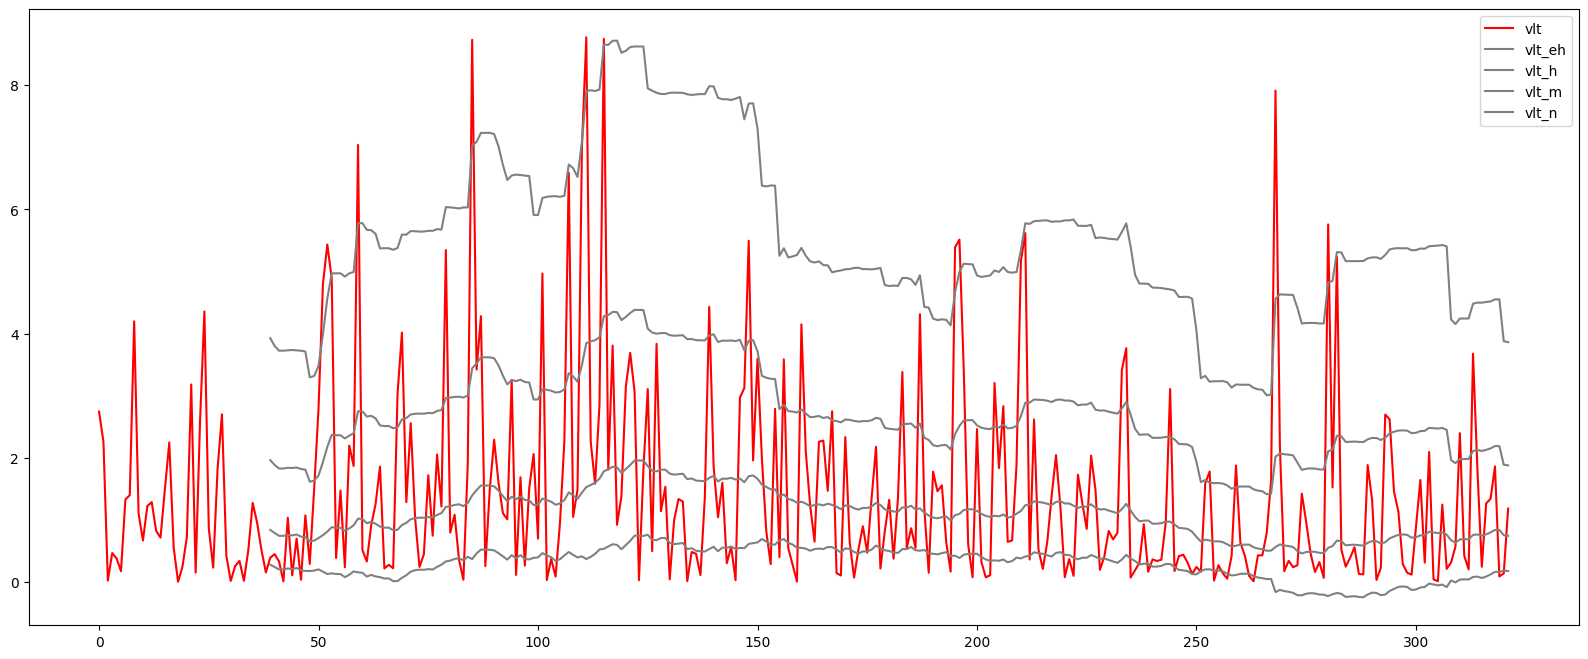

In [50]:
vlt_period = 40
thresholdExtraHigh = 2.5
thresholdHigh = 0.75
thresholdMedium = -0.25
thresholdNormal = -0.75

df['vlt'] = abs( ((df['open']/df['close'])-1)*100 )
df['vlt_mean'] = df['vlt'].rolling(window=vlt_period).mean()
df['vlt_std']  = df['vlt'].rolling(window=vlt_period).std()
df['vlt_eh'] = df['vlt_std'] * thresholdExtraHigh + df['vlt_mean']
df['vlt_h'] = df['vlt_std'] * thresholdHigh + df['vlt_mean']
df['vlt_m'] = df['vlt_std'] * thresholdMedium + df['vlt_mean']
df['vlt_n'] = df['vlt_std'] * thresholdNormal + df['vlt_mean']
df['vlt_range'] = np.where((df['vlt']>0)&(df['vlt']<=df['vlt_n']),1,0)
df['vlt_range'] = np.where((df['vlt']>df['vlt_n'])&(df['vlt']<=df['vlt_m']),2,df['vlt_range'])
df['vlt_range'] = np.where((df['vlt']>df['vlt_m'])&(df['vlt']<=df['vlt_h']),3,df['vlt_range'])
df['vlt_range'] = np.where((df['vlt']>df['vlt_h'])&(df['vlt']<=df['vlt_eh']),4,df['vlt_range'])
df['vlt_range'] = np.where((df['vlt']>df['vlt_eh']),5,df['vlt_range'])

print('0: ',df[df['vlt_range']==0]['vlt_range'].count())
print('1: ',df[df['vlt_range']==1]['vlt_range'].count())
print('2: ',df[df['vlt_range']==2]['vlt_range'].count())
print('3: ',df[df['vlt_range']==3]['vlt_range'].count())
print('4: ',df[df['vlt_range']==4]['vlt_range'].count())
print('5: ',df[df['vlt_range']==5]['vlt_range'].count())
df['vlt_range'].describe()

#El volumen debe estar entre medio (vlt_m) y alto (vlt_h)
df[['vlt','vlt_eh','vlt_h','vlt_m','vlt_n']].plot(figsize=(20,8),style=['red','gray','gray','gray','gray'])

Factor a aplicar a cada par
ADAUSDT    1.547443
DOTUSDT    1.654235
TRXUSDT    1.319380
XRPUSDT    1.725183
ETHUSDT    1.319116
BNBUSDT    1.430593
BTCUSDT    1.000000
Name: mean, dtype: float64


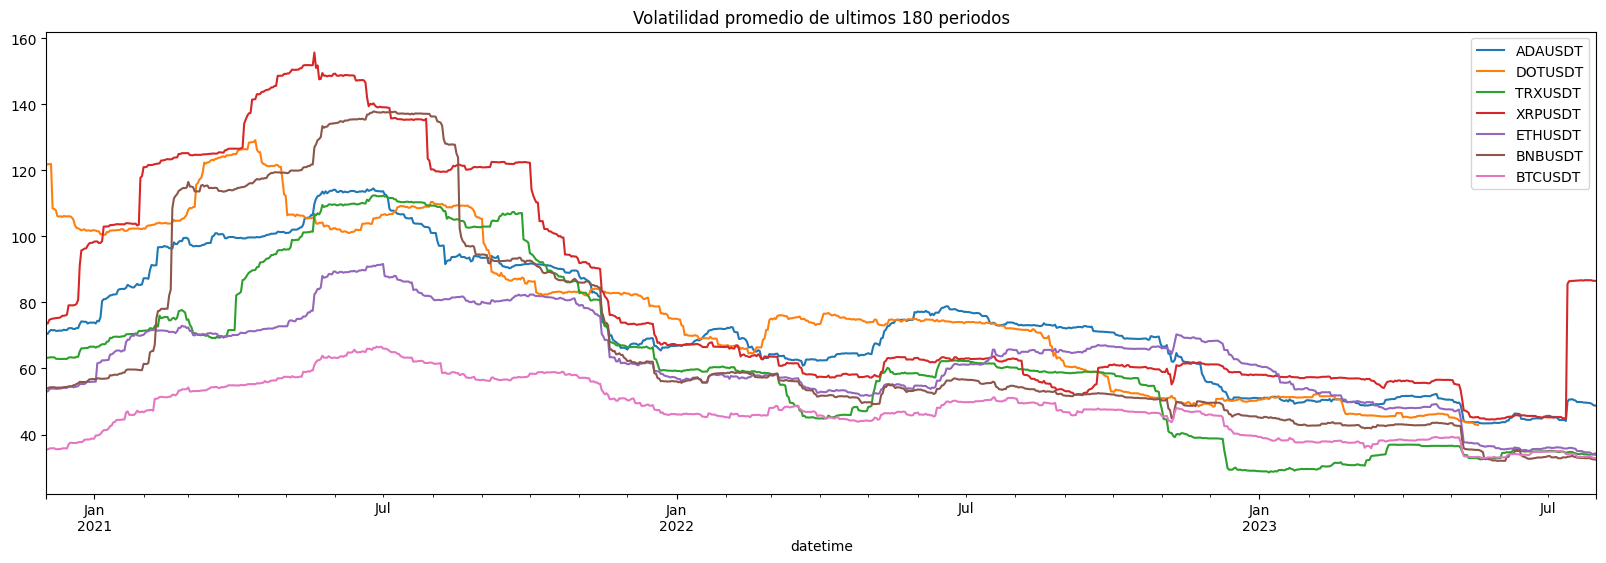

In [21]:
symbols = { 'BTCUSDT',
            'ETHUSDT',
            'BNBUSDT',
            'TRXUSDT',
            'ADAUSDT',
            'DOTUSDT',
            'XRPUSDT',
}

periodos = 180

start = False
for symbol in symbols:
    klines_file = f'./backtest/klines/2d01/Completo_{symbol}_2d01_2021-01-01_2023-07-31.DataFrame'
    with open(klines_file, 'rb') as file:
        tmp_df = pickle.load(file)
        qty_velas = tmp_df['datetime'].count()
        tmp_df[symbol] = tmp_df['close'].pct_change().rolling(periodos).std() * np.sqrt(periodos)*100
        
        if not start:
            df = tmp_df[['datetime',symbol]].copy()
            start = True
        else:
            df[symbol] = tmp_df[symbol].copy()
df.set_index('datetime',inplace=True)

title = f'Volatilidad promedio de ultimos {periodos} periodos'
df[periodos:].plot(figsize=(20,6),title=title)
#print(df[periodos:].describe())
df_std = df[periodos:].describe().loc['mean']

btc_base = df_std['BTCUSDT']
df_std = df_std/btc_base
print('Factor a aplicar a cada par')
print(df_std)
